In [1]:
'''
Location of 'project' directory.
'''
import os

os.chdir('..')
os.chdir('..')

BASE_DIR = os.getcwd()

# BASE_DIR is working directory for this notebook
print(os.getcwd())

D:\ML\Projects\htr\htr-github


## Import libraries

In [2]:
import cv2
import numpy as np
import h5py
from htr.utils import split_data
from htr.preprocessing import preprocess, threshold
from tqdm.notebook import tqdm

## Read data (IAM dataset)

In [3]:
IAM_DIR = os.path.join(BASE_DIR, 'raw', 'iam')

In [4]:
samples = []

with open(os.path.join(IAM_DIR, 'words.txt')) as f:
    for line in f:
        # #: comments
        if not line or line[0] == '#':
            continue
        
        # format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
        linesplit = line.strip().split()
        
        '''
        # er: segmentation of word can be bad
        if linesplit[1].startswith('er'):
            continue
        '''
        
        sample = {}
        filenamesplit = linesplit[0].split('-')
        
        # 'D:\\ML\\Projects\\handwriting-text-recognition\\raw\\iam\\words\\r06\\r06-143\\r06-143-04-10.png'
        sample['imgpath'] = os.path.join(IAM_DIR, 'words', filenamesplit[0], f'{filenamesplit[0]}-{filenamesplit[1]}', f'{linesplit[0]}.png')
        sample['gt_text'] = ' '.join(linesplit[8:])            
        
        # Check if image is empty
        if not os.path.getsize(sample['imgpath']):
            continue
            
        samples.append(sample)

print('# of samples:', len(samples))

# of samples: 115318


## Split data

In [5]:
dataset = split_data(samples, val_split_size=0.05, test_split_size=0.05)

print('Train images:', len(dataset['train']))
print('Validation images:', len(dataset['val']))
print('Test images:', len(dataset['test']))

Train images: 103788
Validation images: 5765
Test images: 5765


## Preprocess samples and save in a HDF5 file
***Some preprocessing examples***

D:\ML\Projects\handwritten-text-recognition\htr\utils.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


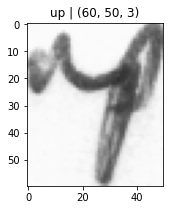

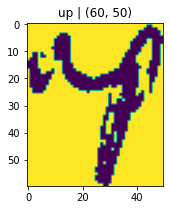

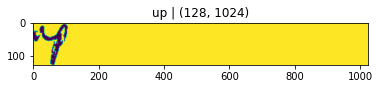

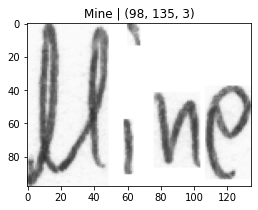

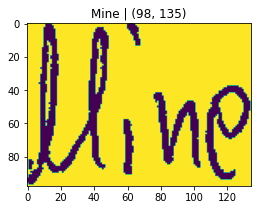

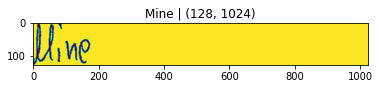

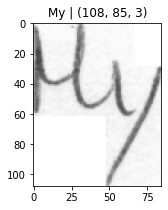

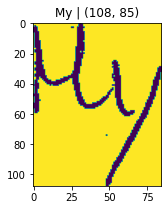

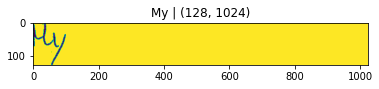

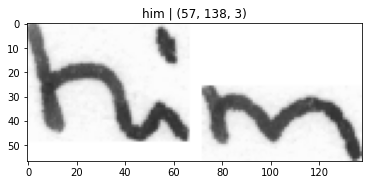

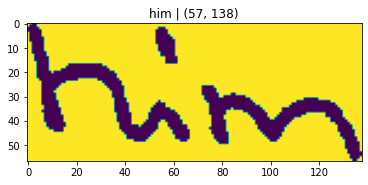

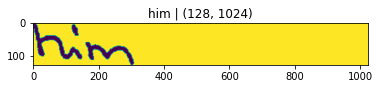

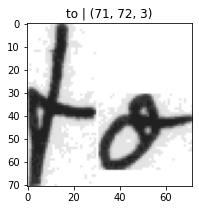

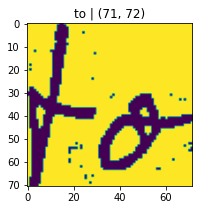

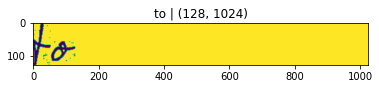

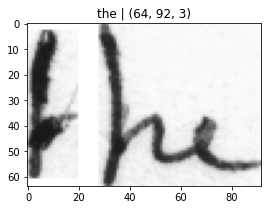

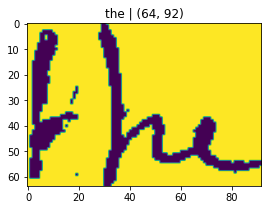

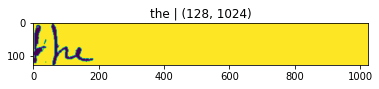

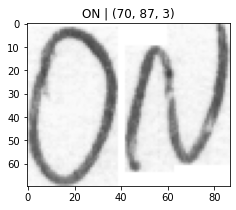

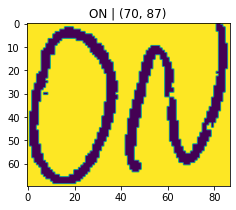

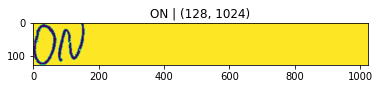

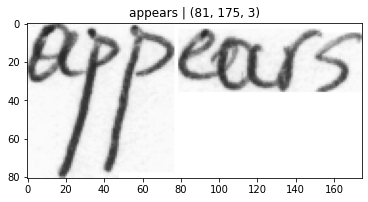

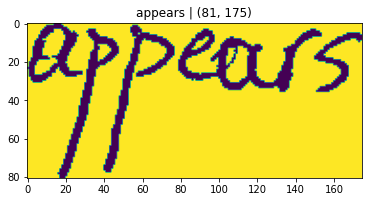

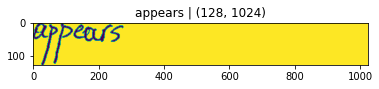

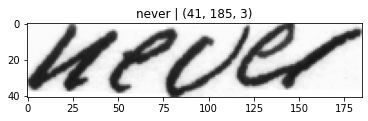

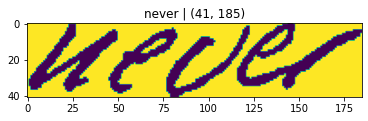

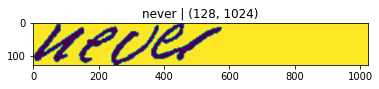

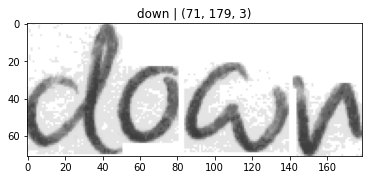

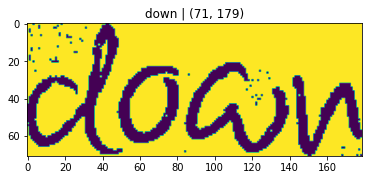

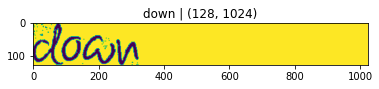

In [6]:
import random
from htr.utils import implt

for sample in random.sample(samples, 10):
    img = cv2.imread(sample['imgpath'])
    implt(img, title=f"{sample['gt_text']} | {img.shape}")
    img = threshold(img, offset=15)
    implt(img, title=f"{sample['gt_text']} | {img.shape}")
    img = preprocess(img, (1024, 128, 1)).transpose()
    implt(img, title=f"{sample['gt_text']} | {img.shape}")

In [7]:
# Parameters
dataset_path = os.path.join(BASE_DIR, 'htr', 'data', 'iam.hdf5')
input_size = (1024, 128, 1)
max_text_len = 128
batch_size = 1024

*HDF5 file structure*

    iam.hdf5
       │    
       ├───train
       │   ├───imgs
       │   └───gt_texts
       ├───val
       │   ├───imgs
       │   └───gt_texts
       ├───test
           ├───imgs
           └───gt_texts

In [8]:
with h5py.File(dataset_path, 'w') as hf:
    for s in ['train', 'val', 'test']:
        # Dummy imgs
        hf.create_dataset(f'{s}/imgs',
                          data=np.zeros(shape=(len(dataset[s]), input_size[0], input_size[1]), dtype=np.uint8),
                          compression='gzip',
                          compression_opts=9)
        # Dummy ground truth texts
        hf.create_dataset(f'{s}/gt_texts',
                          data=[('c' * max_text_len).encode()] * len(dataset[s]), 
                          compression='gzip', 
                          compression_opts=9)

In [9]:
for s in ['train', 'val', 'test']:
    print(s)
    for batch in tqdm(range(0, len(dataset[s]), batch_size)):
        imgs = [preprocess(threshold(cv2.imread(sample['imgpath']), offset=15), input_size) for sample in dataset[s][batch : batch + batch_size]]
        gt_texts = [sample['gt_text'].encode() for sample in dataset[s][batch : batch + batch_size]]
        
        with h5py.File(dataset_path, 'a') as hf:
            hf[f'{s}/imgs'][batch : batch + batch_size] = imgs
            hf[f'{s}/gt_texts'][batch : batch + batch_size] = gt_texts

train



val



test
